### Goal
The goal of this notebook is to classify examples into different categories, specifically identifying spam vs. non-spam emails using a generated dataset.

### Dataset
Instead of using a pre-existing dataset, we generate a synthetic dataset of ham and spam emails. Each email is saved as an individual text file in respective `ham` and `spam` directories. This approach ensures flexibility and control over the dataset.

### Generate Dataset
Before starting, we generate the spam and ham datasets.

In [22]:
import os
import random

# Define the folder structure
base_path = "../data"
ham_path = os.path.join(base_path, "ham")
spam_path = os.path.join(base_path, "spam")

# Create directories if they don't exist
os.makedirs(ham_path, exist_ok=True)
os.makedirs(spam_path, exist_ok=True)

# Define templates for spam and ham messages
spam_templates = [
    "Congratulations! You've won ${} in cash rewards. Claim now!",
    "Limited offer: Get {}% discount on all items. Expires soon.",
    "Alert: Your account {} has been compromised. Secure it immediately.",
    "Win a free {} by signing up today. Don't miss out!",
    "Earn ${}/week working remotely. Apply now!",
    "Exclusive deal: Get {}% cashback on your next purchase.",
    "You are the lucky winner of a new {}. Redeem your prize!",
    "Urgent: Your subscription will expire in {} days. Renew now!",
    "Flash sale: Up to {}% off on top brands. Shop now!",
    "Act fast: {} bonus points added to your account. Redeem today!",
]

ham_templates = [
    "Meeting rescheduled to {} PM tomorrow. Let me know if you can join.",
    "Reminder: Submit your report by {} PM today.",
    "Don't forget about the team lunch at {} PM on Friday.",
    "Can we discuss the project updates at {} PM next Monday?",
    "Please review the attached document and share your feedback by {} PM.",
    "Here is the link to the repository. Please update it before {} PM.",
    "Looking forward to our call at {} PM. Let me know if it works for you.",
    "Can we finalize the budget discussion at {} PM on Thursday?",
    "Reminder: Complete the assigned tasks before {} PM.",
    "Join us for the workshop at {} PM this weekend. Let me know if you're interested.",
]

# Generate unique messages with specific parameters
def generate_messages(templates, num_messages, value_range):
    messages = []
    for i in range(num_messages):
        template = templates[i % len(templates)]
        filled_message = template.format(random.randint(*value_range))
        messages.append(filled_message)
    return messages

# Generate 100 unique messages for spam and ham
spam_emails = generate_messages(spam_templates, 100, (100, 5000))
ham_emails = generate_messages(ham_templates, 100, (1, 12))

# Save ham emails as individual files
for i, email in enumerate(ham_emails, 1):
    with open(f"{ham_path}/ham{i}.txt", "w", encoding="utf-8") as file:
        file.write(email)

# Save spam emails as individual files
for i, email in enumerate(spam_emails, 1):
    with open(f"{spam_path}/spam{i}.txt", "w", encoding="utf-8") as file:
        file.write(email)

print("Data generation completed. Ham and spam emails saved in respective folders.")


Data generation completed. Ham and spam emails saved in respective folders.


## 2. Import Libraries and Load Data

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk

# Ensure the download directory is correctly set
nltk_data_path = '../nltk_data'
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

nltk.data.path.append(nltk_data_path)

# Explicitly download required NLTK data
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)

# Verify downloads
assert os.path.exists(os.path.join(nltk_data_path, 'tokenizers/punkt/english.pickle')), "Punkt tokenizer not found!"
assert os.path.exists(os.path.join(nltk_data_path, 'corpora/stopwords/english')), "Stopwords not found!"

### Load Data

import os

def load_spamassassin_data(ham_dir, spam_dir):
    data = []
    labels = []

    # Load ham emails
    for filename in os.listdir(ham_dir):
        with open(os.path.join(ham_dir, filename), 'r', encoding='latin-1') as file:
            data.append(file.read())
            labels.append(0)  # 0 for non-spam

    # Load spam emails
    for filename in os.listdir(spam_dir):
        with open(os.path.join(spam_dir, filename), 'r', encoding='latin-1') as file:
            data.append(file.read())
            labels.append(1)  # 1 for spam

    return pd.DataFrame({'text': data, 'label': labels})

# Load the dataset
df = load_spamassassin_data('../data/ham', '../data/spam')

# Display the first few rows
df.head()

[nltk_data] Downloading package punkt_tab to ../nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to ../nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to ../nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,Join us for the workshop at 8 PM this weekend....,0
1,Reminder: Complete the assigned tasks before 4...,0
2,Here is the link to the repository. Please upd...,0
3,Reminder: Submit your report by 9 PM today.,0
4,Don't forget about the team lunch at 9 PM on F...,0


## 3. Preprocessing


In [24]:
### Advanced Text Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Use TF-IDF Vectorizer to convert text to feature vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Transform the data
X = vectorizer.fit_transform(df['text'])
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Model Training

In [25]:
# Train Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Train K-Nearest Neighbors model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Train Support Vector Machine model
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Train Decision Tree model
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Train Random Forest model
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

## 5. Model Evaluation


In [26]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Dictionary to store results
results = {}

# Evaluate Logistic Regression
results['Logistic Regression'] = evaluate_model(log_reg, X_test, y_test)

# Evaluate K-Nearest Neighbors
results['K-Nearest Neighbors'] = evaluate_model(knn, X_test, y_test)

# Evaluate Support Vector Machines
results['Support Vector Machines'] = evaluate_model(svm, X_test, y_test)

# Evaluate Decision Tree
results['Decision Tree'] = evaluate_model(tree, X_test, y_test)

# Evaluate Random Forest
results['Random Forest'] = evaluate_model(forest, X_test, y_test)

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,1.0,1.0,1.0,1.0,1.0
K-Nearest Neighbors,1.0,1.0,1.0,1.0,1.0
Support Vector Machines,1.0,1.0,1.0,1.0,1.0
Decision Tree,1.0,1.0,1.0,1.0,1.0
Random Forest,1.0,1.0,1.0,1.0,1.0


## 6.Visualize Results


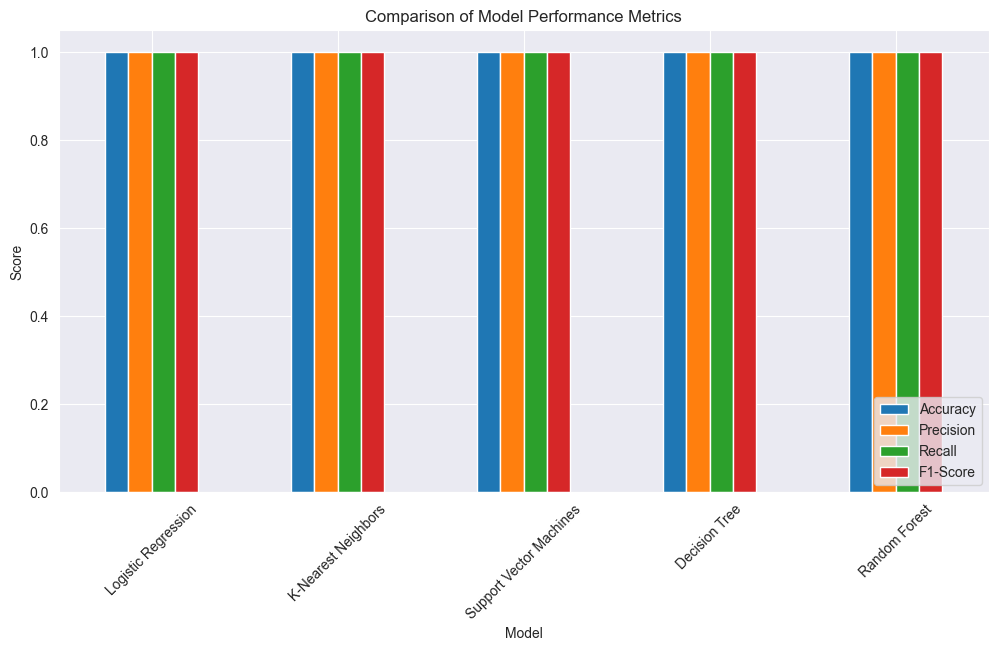

In [27]:
# Compare evaluation metrics
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

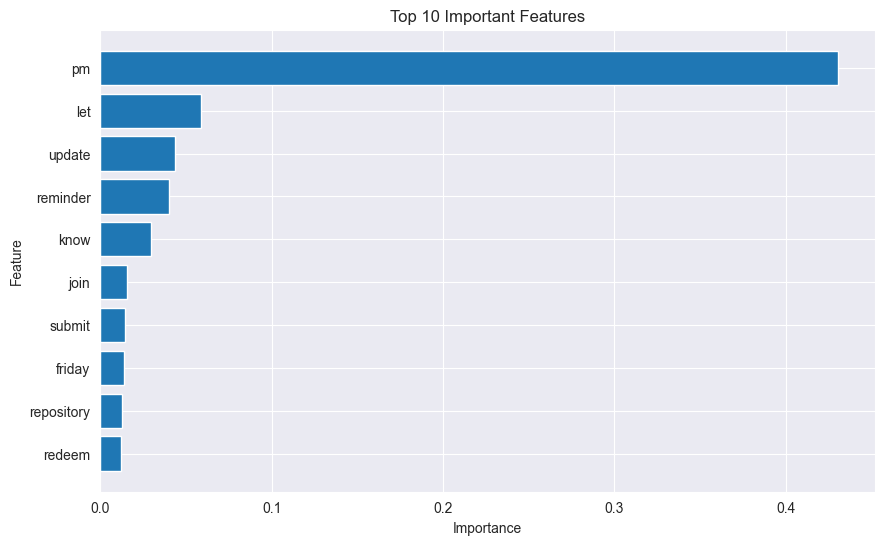

In [28]:
### Feature Importance for Random Forest
importances = forest.feature_importances_
indices = np.argsort(importances)[-10:]
features = np.array(vectorizer.get_feature_names_out())[indices]

plt.figure(figsize=(10, 6))
plt.barh(features, importances[indices])
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

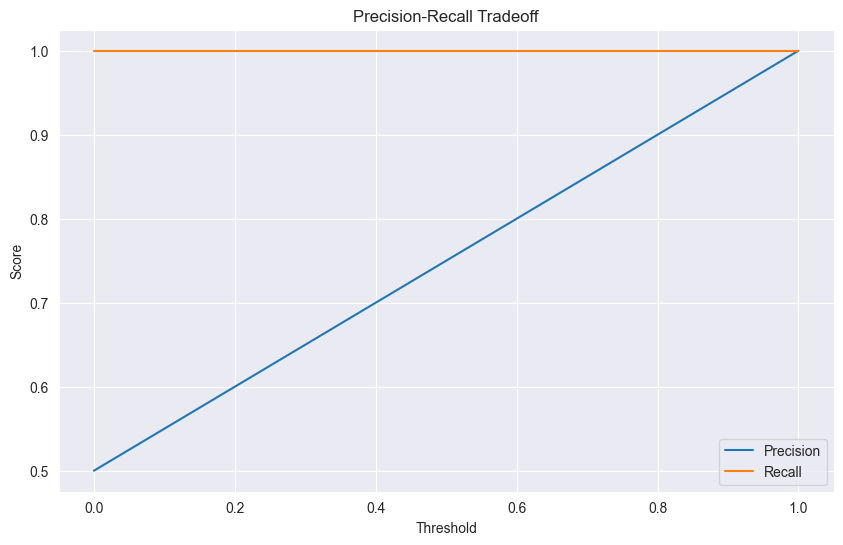

In [29]:
### Adjust Decision Threshold

from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve for Random Forest
probs = forest.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.title('Precision-Recall Tradeoff')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()